## Latent Space and Song Orders
We can now use the trained Autoencoder (ML1) to get the latent representation of the snippet-spectrograms. The latent space is a 128 dimensional representation of the snippets ordered by similiarity. Each snippet is a point in the 128D space. We can think of a song as a series of jumps from snippet to snippet, i.e. a sequence of 128D coordinates. We want to save these series and train another network (ML2) to create a new series in the next step. Here we're going to create the training data for that network, i.e. the sequences of 128D coordinates for each song.

In [1]:
from Variational_Autoencoder_alla_Valerio import VAE as Autoencoder
from Snippets import Snippets
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import librosa.feature.inverse
from IPython.display import display, Audio
import os
import gc

First we load the trained autoencoder and the training data from our disk. Change the path, if you have trained your own model.

In [2]:
subfolder = "2.0_128"
model_name = "VAE_Vocals_128D_45480samples_40Epochs"
path = os.path.join("data_and_models", subfolder, model_name) # Change this path if you have trained your own model
autoencoder = Autoencoder.load(path)

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
num = 500
def load_data(subfolder):
    # Load the Snippet-Spectograms
    specto_path = os.path.join("data_and_models", subfolder, "spectos" + str(num) + ".npy")
    spectogram_data = np.load(specto_path)
    
    # Load the Song_Labels (Note that we didn't use them during training. We only use them for demonstration purposes.)
    labels_path = speto_path = os.path.join("data_and_models", subfolder, "song_labels" + str(num) + ".npy")
    song_labels = np.load(labels_path)
    
    # Load the Position_Labels (Note that we didn't use them during training. We only use them for demonstration purposes.)
    pos_label_path = os.path.join("data_and_models", subfolder, "position_labels" + str(num) + ".npy")
    position_labels = np.load(pos_label_path)
    
    print("Shape of the loaded data: " + str(spectogram_data.shape))
    
    return spectogram_data, position_labels, song_labels

spectos, pos_labels, song_labels = load_data(subfolder)

Shape of the loaded data: (56861, 128, 128, 1)


## Data in latent space
We use our trained encoder to get the latent space representation of all snippets.

In [4]:
latent_representation = autoencoder.encoder.predict(spectos)

D:\Daten\Studium\Semester_7\MusikInfo\MetaHuman\venv\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


We can now plot the dots in the latent space. Each snippet is reduced to a dot in the 128 dimensional space. We can look at the first two dimensions of the coordintaes. The colors represent at which position in a song the snippet occured (first 10% of the song, second 10% of the song and so on).

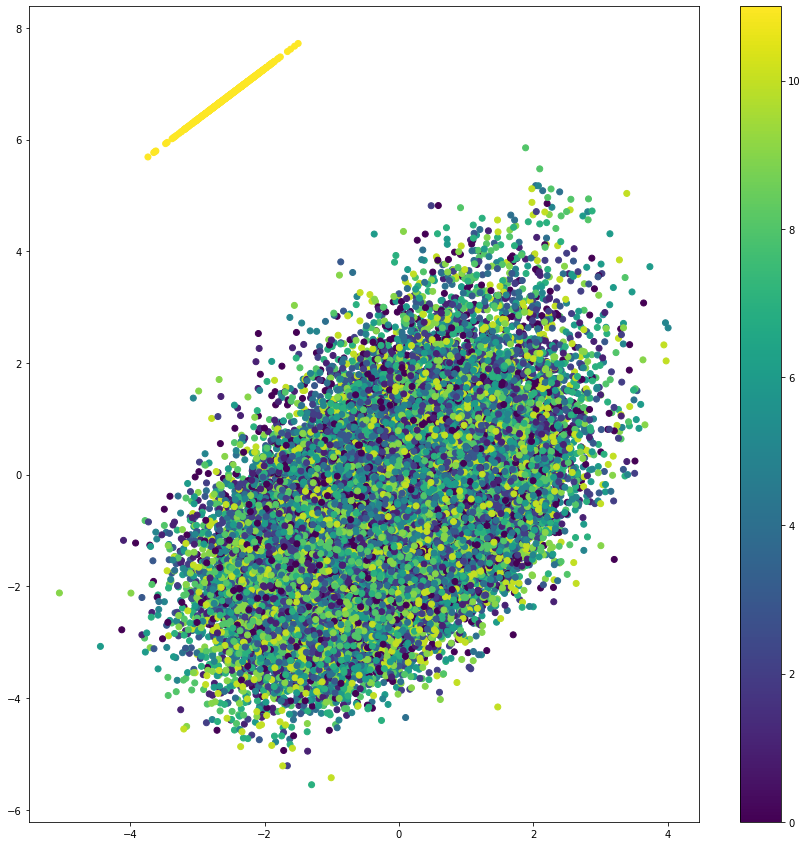

In [5]:
plt.figure(figsize=(15, 15))
plt.scatter(latent_representation[:, 0], latent_representation[:, 1], c=pos_labels)
plt.colorbar()
plt.show()

To make things easier for our the ML2, that will learn the song orders, we're going to delete the outliers. As you can see they all come from snippets at the end of a song. Probably they are silence.

In [6]:
def reject_outliers(data, labels1, labels2, m = 10):
    
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    
    indices = []
    for i, coordinate in enumerate(s):
        if coordinate.max() > m:
            indices.append(i)
    
    filtered = np.delete(data, indices, axis=0)
    filtered_labels1 = np.delete(labels1, indices, axis=0)
    filtered_labels2 = np.delete(labels2, indices, axis=0)
    return filtered, filtered_labels1, filtered_labels2

latent_representation_filtered, pos_labels_filtered, song_labels_filtered = reject_outliers(latent_representation, pos_labels, song_labels)

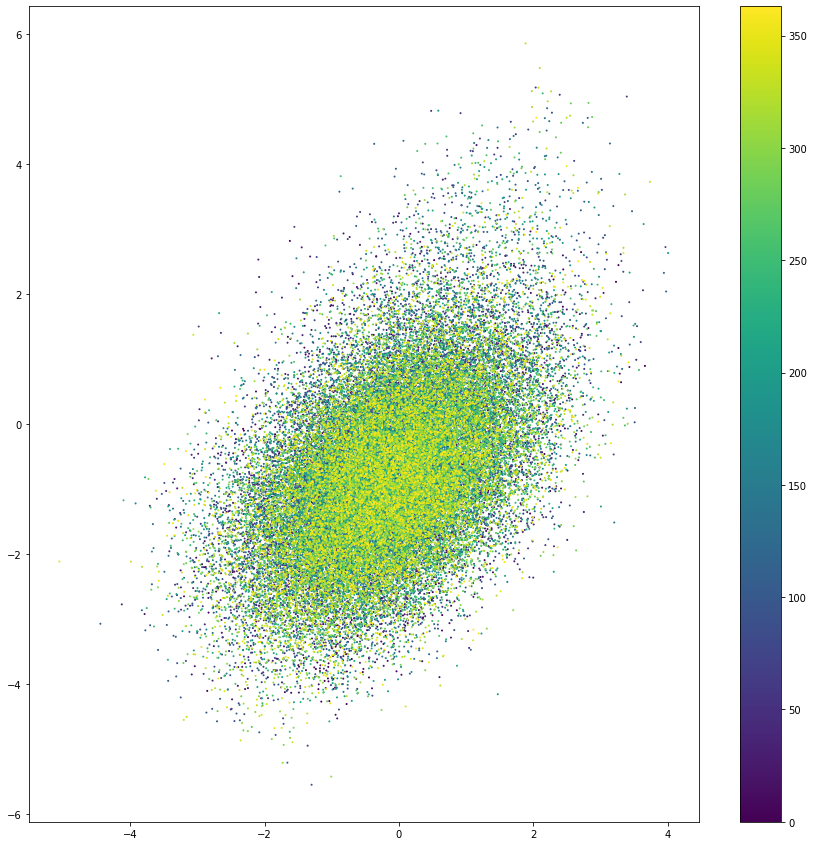

In [7]:
plt.figure(figsize=(15, 15))
plt.scatter(latent_representation_filtered[:, 0], latent_representation_filtered[:, 1], c=song_labels_filtered, s=1)
plt.colorbar()
plt.show()

In [8]:
path = os.path.join("data_and_models", subfolder, model_name +  "_latent_representations_filtered" + str(num) + ".npy")
np.save(path, latent_representation_filtered)

## Generate Song Orders
A song is a series of snippets. This series of snippets corresponds to a list of coordinates in the latent space. It can be imagined as a movement - or more precisely a sequence of jumps - through the latent space. Later we want to use these sequences as training data for ML2. On their basis the second network will be able to produce new sequences. For this we need to store the series of coordinates for each song. We create a list of coordinates:

In [9]:
start_snippets = np.where(song_labels_filtered[:-1] != song_labels_filtered[1:])[0]

song_orders = []
start_snippet = 0
end_snippet = 0


for start in start_snippets:
    end_snippet = start
    song_order = latent_representation_filtered[start_snippet:end_snippet]
    song_orders.append(song_order)
    start_snippet = end_snippet

song_orders = np.asarray(song_orders, dtype=object)    
song_orders.shape

(363,)

We save the new list of song_orders on disk for later use:

In [10]:
save_path = os.path.join("data_and_models", subfolder, model_name + "_song_order" + str(num) + ".npy")
np.save(save_path,song_orders)

## The latent space representation of one song
We can plot the latent representation of a song. The subsequent snippets are connected by lines to visualize, that the sequence of snippets corresponds to a path trough the latent space.

In [11]:
save_path = os.path.join("data_and_models", subfolder, model_name + "_song_order" + str(num) + ".npy")
song_orders=np.load(save_path, allow_pickle=True)

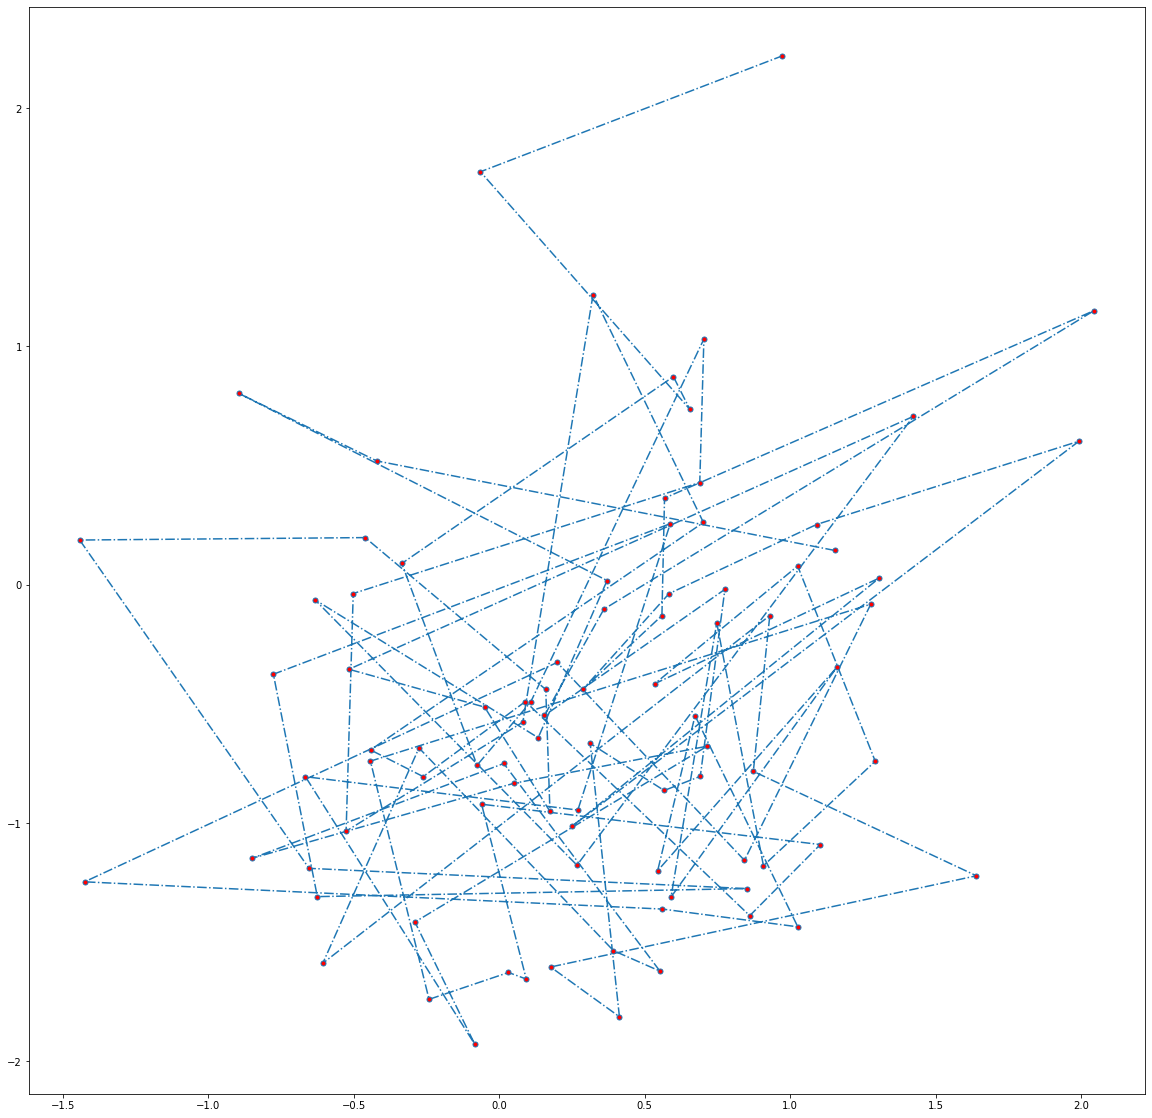

In [12]:
song_num = np.random.randint(0, len(song_orders))
plt.figure(figsize=(20,20))
plt.plot(song_orders[song_num][:, 0], song_orders[song_num][:, 1], '-.o', markersize=5, markerfacecolor='red')
plt.show()

## Create a new Snippets
We can try the conversion, by letting the autoencoder reconstruct a snippet of audio. We feed the spectrograms of some audio-snippets to the encoder to get their latent representation. We can then test how much information gets lost in the autoencoder by passing the latent representation to our decoder, which will spit out a reconstructed spectrogram, which we can then use to reconstruct pcm-data. 

In [13]:
WIN_LENGTH = 690*2
HOP_LENGTH = 690
N_FFT = 690*2

index = np.random.randint(0, spectos.shape[0]) # Choose a random snippet as the start

Reconstructed 10 of 10 spectos
Original Specto



D:\Daten\Studium\Semester_7\MusikInfo\MetaHuman\venv\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
D:\Daten\Studium\Semester_7\MusikInfo\MetaHuman\venv\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


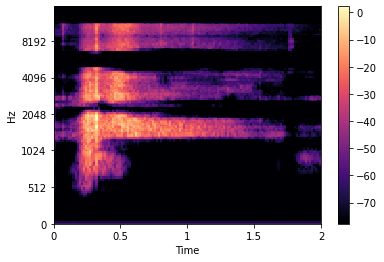


 This is the original Audio:


In [14]:
original_signal, original_spectos = Snippets.reconstructed_spectos_to_pcm(spectos[index:index+10], hop_length=HOP_LENGTH, n_fft=N_FFT, win_length=WIN_LENGTH)
Snippets.plot_specto(original_spectos, "Original Specto", HOP_LENGTH)
print("\n This is the original Audio:")
display(Audio(original_signal,rate=44100))

In [15]:
test_spectos = spectos[index:index+10]
# del spectos
# gc.collect()

D:\Daten\Studium\Semester_7\MusikInfo\MetaHuman\venv\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Reconstructed 10 of 10 spectos
Reconstructed Specto



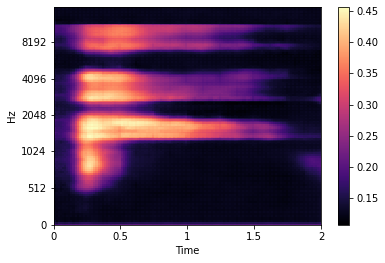


 This is the reconstructed Audio:


In [16]:
recon_signal, recon_specto = Snippets.specto_to_pcm(data=test_spectos, 
                                                    model=autoencoder, 
                                                    hop_length=HOP_LENGTH, 
                                                    n_fft=N_FFT, 
                                                    win_length=WIN_LENGTH)
Snippets.plot_specto(recon_specto, "Reconstructed Specto", HOP_LENGTH)
print("\n This is the reconstructed Audio:")
display(Audio(recon_signal,rate=44100))

We can also try what happens, if we use random points in the latent space and use them as coordinates for our song. We sample a random point, reconstruct the corresponding spectogram and use it to reconstruct pcm-data.

In [17]:
random_points = np.random.rand(10, 128)#latent_representation.shape[1])
random_points = (random_points * 4) - 2 # We center the random points around the origin
random_points

array([[-0.65247468, -1.21450202,  1.29131089, ..., -1.93375233,
         0.02794852,  1.03875454],
       [ 0.94790093,  0.85729921,  0.3940177 , ..., -1.38577232,
        -0.91147229,  1.80178178],
       [ 1.671186  , -0.20009874,  0.25712772, ...,  0.7572326 ,
         1.27463979, -1.53678137],
       ...,
       [-1.88824575, -1.95818904, -1.5116803 , ...,  0.72080376,
        -0.21101233, -0.04826263],
       [ 1.22421254,  0.80124114,  1.81624635, ...,  0.94738618,
        -0.57103695,  0.06460665],
       [ 0.52632583, -0.0417443 , -0.74191902, ...,  0.51564214,
         0.68835812, -1.84256041]])

Reconstructed 10 of 10 spectos
Random Specto



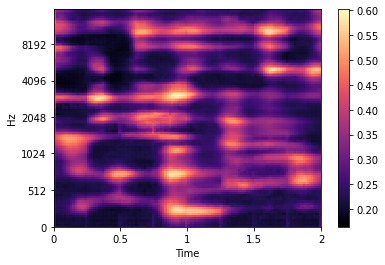


 This is the reconstruction of random points in the latent space:


In [18]:
random_signal, random_spectos = Snippets.latent_representation_to_pcm(latent_representations=random_points,
                                                                      model=autoencoder,
                                                                      hop_length=HOP_LENGTH, 
                                                                      n_fft=N_FFT, 
                                                                      win_length=WIN_LENGTH)
Snippets.plot_specto(random_spectos, "Random Specto", HOP_LENGTH)
print("\n This is the reconstruction of random points in the latent space:")
display(Audio(random_signal,rate=44100))